In [2]:
import sys
from absl import logging
logging.get_absl_handler().python_handler.stream = sys.stdout

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2024-06-16 04:25:00.901803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 04:25:00.901915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 04:25:01.026370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Preparing Dataset

In [7]:
IMG_WIDTH = 112
IMG_HEIGHT = 112
IMG_CHANNELS = 3
SAMPLES = 21000  #train 42000
SAMPLES2 = 9000  #validation
SAMPLES3 = 9000  #test
CATEGORIES = 1 # 1 for binary classification problem

x_train = np.zeros((SAMPLES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
y_train = np.zeros((SAMPLES, CATEGORIES), dtype='int32')

x_val = np.zeros((SAMPLES2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
y_val = np.zeros((SAMPLES2, CATEGORIES), dtype='int32')

x_test = np.zeros((SAMPLES2, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='float32')
y_test = np.zeros((SAMPLES2, CATEGORIES), dtype='int32')

label_code = {'indoor':0, 'outdoor':1}

In [8]:
#training dataset
i = 0
for dirname, _, filenames in os.walk('./training/indoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_train[i,:,:,:3]  = _img
        y_train[i,0] = 0
        i += 1
        if i==10500:
            break

for dirname, _, filenames in os.walk('./training/outdoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_train[i,:,:,:3]  = _img
        y_train[i,0] = 1
        i += 1
        if i==21000:
            break

#validation dataset
i = 0
for dirname, _, filenames in os.walk('./validation/indoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_val[i,:,:,:3]  = _img
        y_val[i,0] = 0
        i += 1
for dirname, _, filenames in os.walk('./validation/outdoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_val[i,:,:,:3]  = _img
        y_val[i,0] = 1
        i += 1

100%|██████████| 4500/4500 [00:16<00:00, 277.32it/s]


In [17]:
#testing dataset
i = 0
for dirname, _, filenames in os.walk('./testing/indoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_test[i,:,:,:3]  = _img
        y_test[i,0] = 0
        i += 1
for dirname, _, filenames in os.walk('./testing/outdoor'):
    for filename in tqdm(filenames):
        _path = os.path.join(dirname, filename)
        _img = load_img(_path, color_mode = "rgb", target_size=(IMG_HEIGHT, IMG_WIDTH))  #h, w
        _img = np.array(_img, dtype = 'float32')
        _img = preprocess_input(_img)
        x_test[i,:,:,:3]  = _img
        y_test[i,0] = 1
        i += 1

100%|██████████| 4500/4500 [00:27<00:00, 166.08it/s]


In [5]:
#Random Suffling training data
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=123)

## Model Setup

In [12]:
# mport xception model with imagenet weights
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(112, 112, 3),include_top=False) 

# freeze the base model
base_model.trainable = False

#add layers on the base model
inputs = tf.keras.Input(shape=(112, 112, 3))
# x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid' )(x)
model = tf.keras.Model(inputs, outputs)

#checkout the summary
model.summary()

/tmp/ipykernel_989/2865796948.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights='imagenet',input_shape=(112, 112, 3),include_top=False)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,009 (8.77 MB)

 Trainable params: 41,025 (160.25 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Trainning and Evaluation

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
hist = model.fit(x = x_train, y = y_train, batch_size = 32, validation_data=(x_val,y_val), epochs=4, verbose=1, shuffle= True)

Epoch 1/4
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.8794 - loss: 0.2886 - val_accuracy: 0.9264 - val_loss: 0.1884
Epoch 2/4
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9350 - loss: 0.1705 - val_accuracy: 0.9149 - val_loss: 0.2115
Epoch 3/4
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9453 - loss: 0.1464 - val_accuracy: 0.9311 - val_loss: 0.1856
Epoch 4/4
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9525 - loss: 0.1286 - val_accuracy: 0.9333 - val_loss: 0.1824


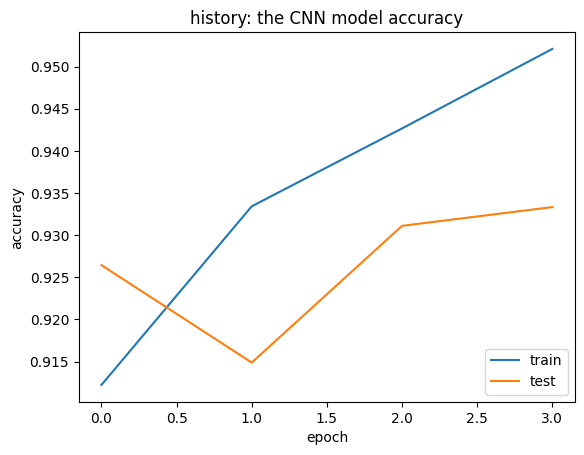

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('history: the CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

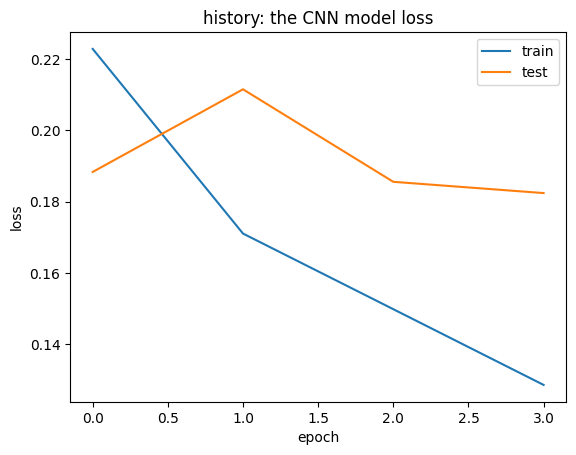

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('history: the CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
# evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

compile_metrics: 93.66%


## Save model

In [21]:
model.save_weights('idod.weights.h5')